In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

#sns.set()

%matplotlib inline

1. initialize data
- drop MAR,MCAR missing value
- fill MNAR missing value
- type convert(date,price,etc)
- drop outliers
2. feature engineering
- multicollinearity
- one hot encode
3. quick random forest: see the important features
4. tune paremeters

# Initialize Data

In [2]:
df2024_1=pd.read_csv('Data/df2024_1.csv')

In [3]:
df2024_1.drop(['id', 'listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license'],axis=1,inplace=True)

In [4]:
df2024_1.dtypes

last_scraped                                     object
host_since                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood_cleansed                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bathrooms_text                                   object
bedrooms                                        float64
beds                                            float64
amenities                                        object
price                                           

In [5]:
df2024_1.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,39202.000000,24335.000000,33011.000000,24222.000000,39202.000000,3.920200e+04,39200.000000,39200.000000,3.920000e+04,3.920000e+04,...,27713.000000,27698.000000,27708.000000,27696.000000,27697.000000,39202.000000,39202.000000,39202.000000,39202.000000,27702.000000
mean,2.848860,1.202979,1.403532,1.681736,29.634432,5.640459e+04,29.583495,37.791480,7.686786e+05,1.700019e+06,...,4.629591,4.814092,4.808529,4.727991,4.624456,46.842661,24.227565,21.772690,0.050508,0.953946
std,2.029674,0.556281,0.953565,1.254421,30.172981,1.084709e+07,32.040758,60.007764,4.057712e+07,6.036737e+07,...,0.553984,0.420550,0.448769,0.418802,0.518733,146.693303,120.567818,86.976619,0.369496,1.633604
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.000000,1.000000,1.000000,1.000000,30.000000,1.500000e+02,30.000000,30.000000,3.650000e+02,3.650000e+02,...,4.500000,4.800000,4.800000,4.630000,4.510000,1.000000,0.000000,0.000000,0.000000,0.100000
50%,2.000000,1.000000,1.000000,1.000000,30.000000,3.650000e+02,30.000000,30.000000,1.125000e+03,1.125000e+03,...,4.800000,4.940000,4.960000,4.840000,4.760000,1.000000,1.000000,1.000000,0.000000,0.360000
75%,4.000000,1.000000,2.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,...,5.000000,5.000000,5.000000,5.000000,4.930000,6.000000,2.000000,2.000000,0.000000,1.300000
max,16.000000,15.500000,26.000000,42.000000,1250.000000,2.147484e+09,1250.000000,1250.000000,2.147484e+09,2.147484e+09,...,5.000000,5.000000,5.000000,5.000000,5.000000,827.000000,827.000000,599.000000,8.000000,78.250000


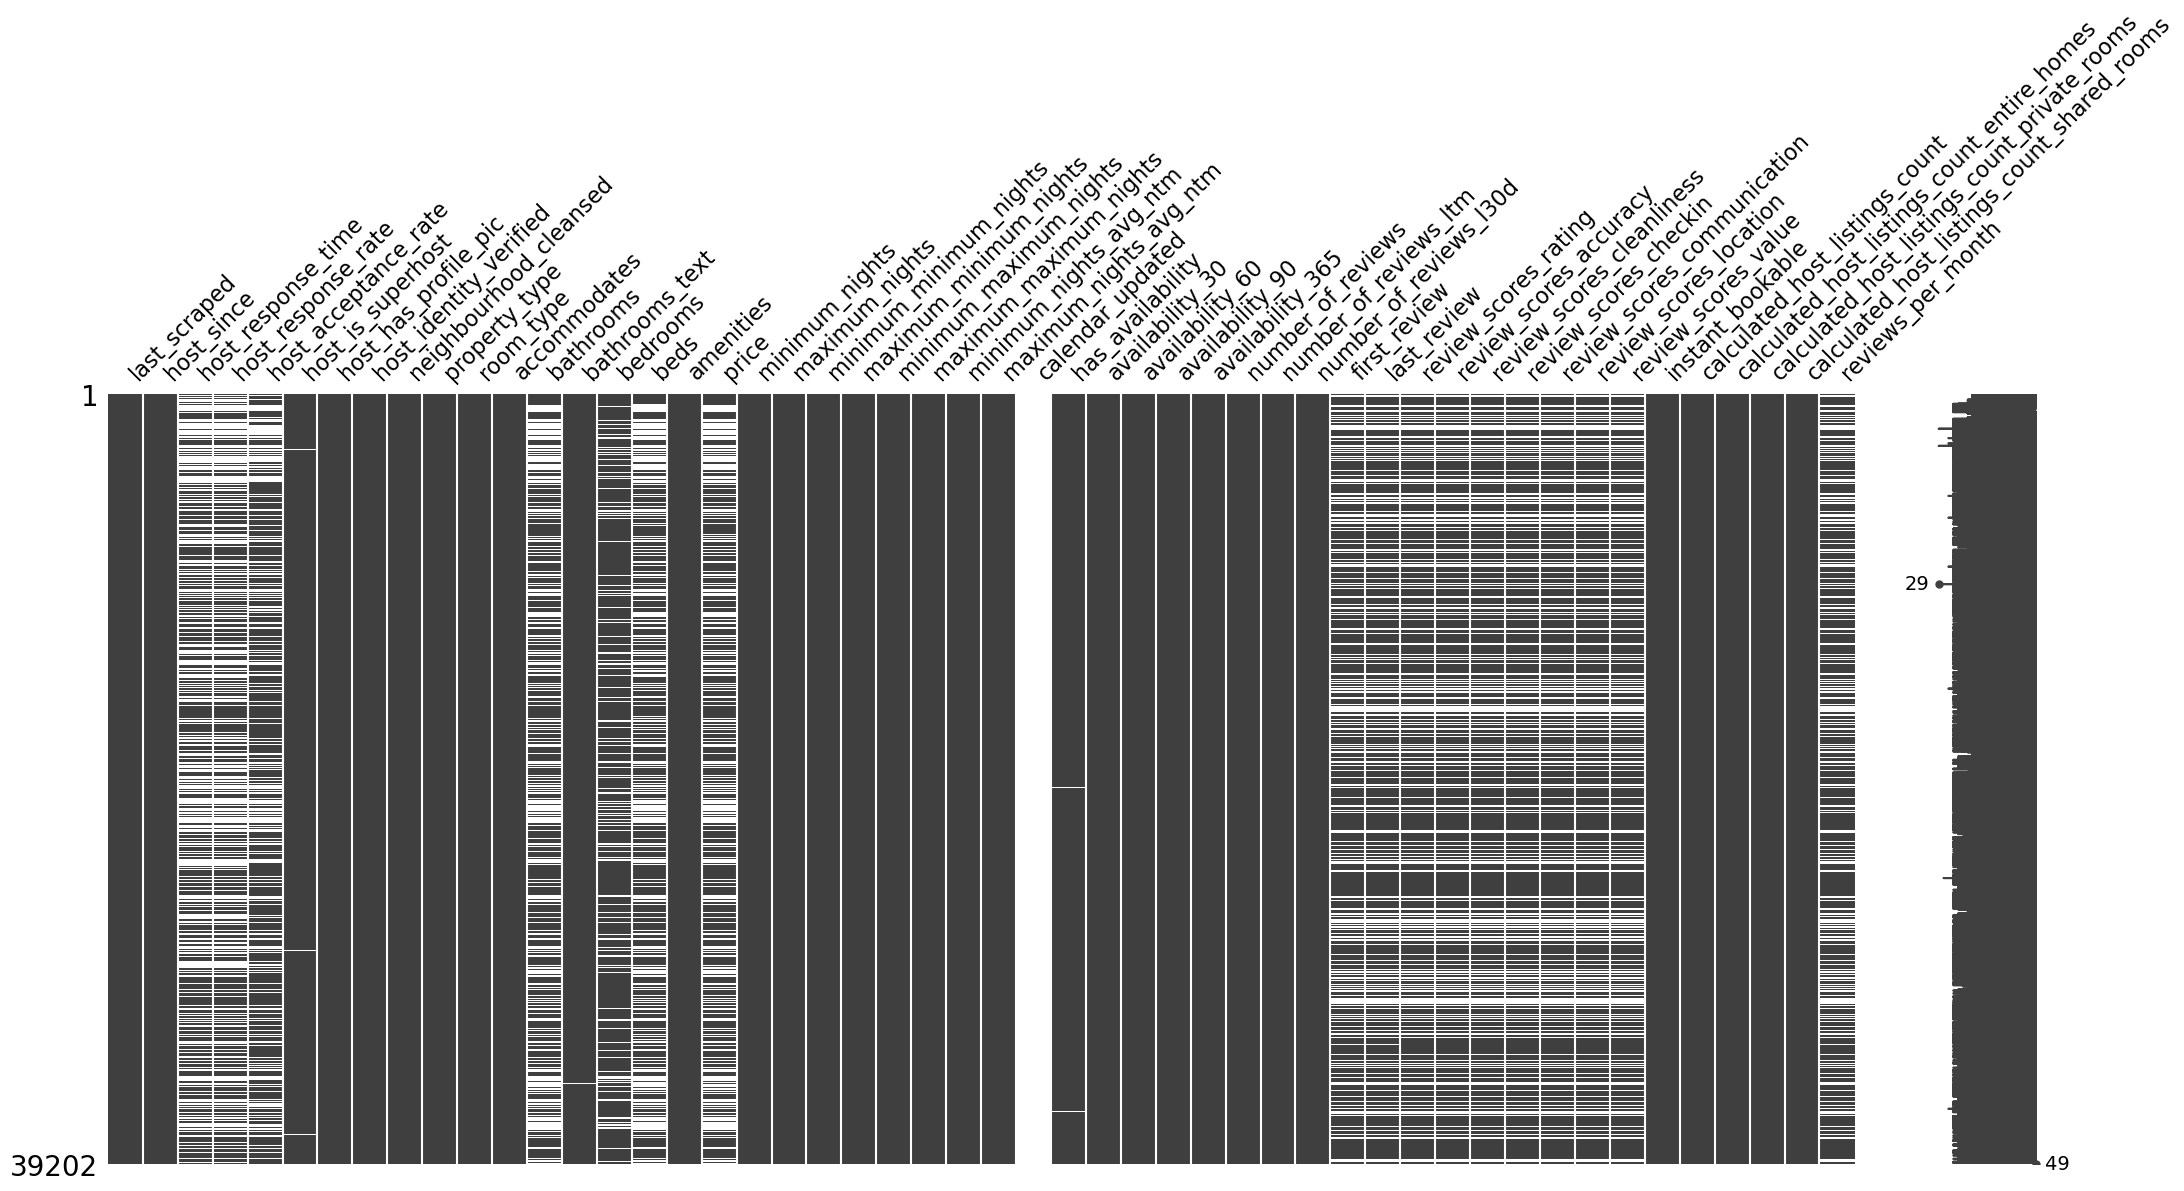

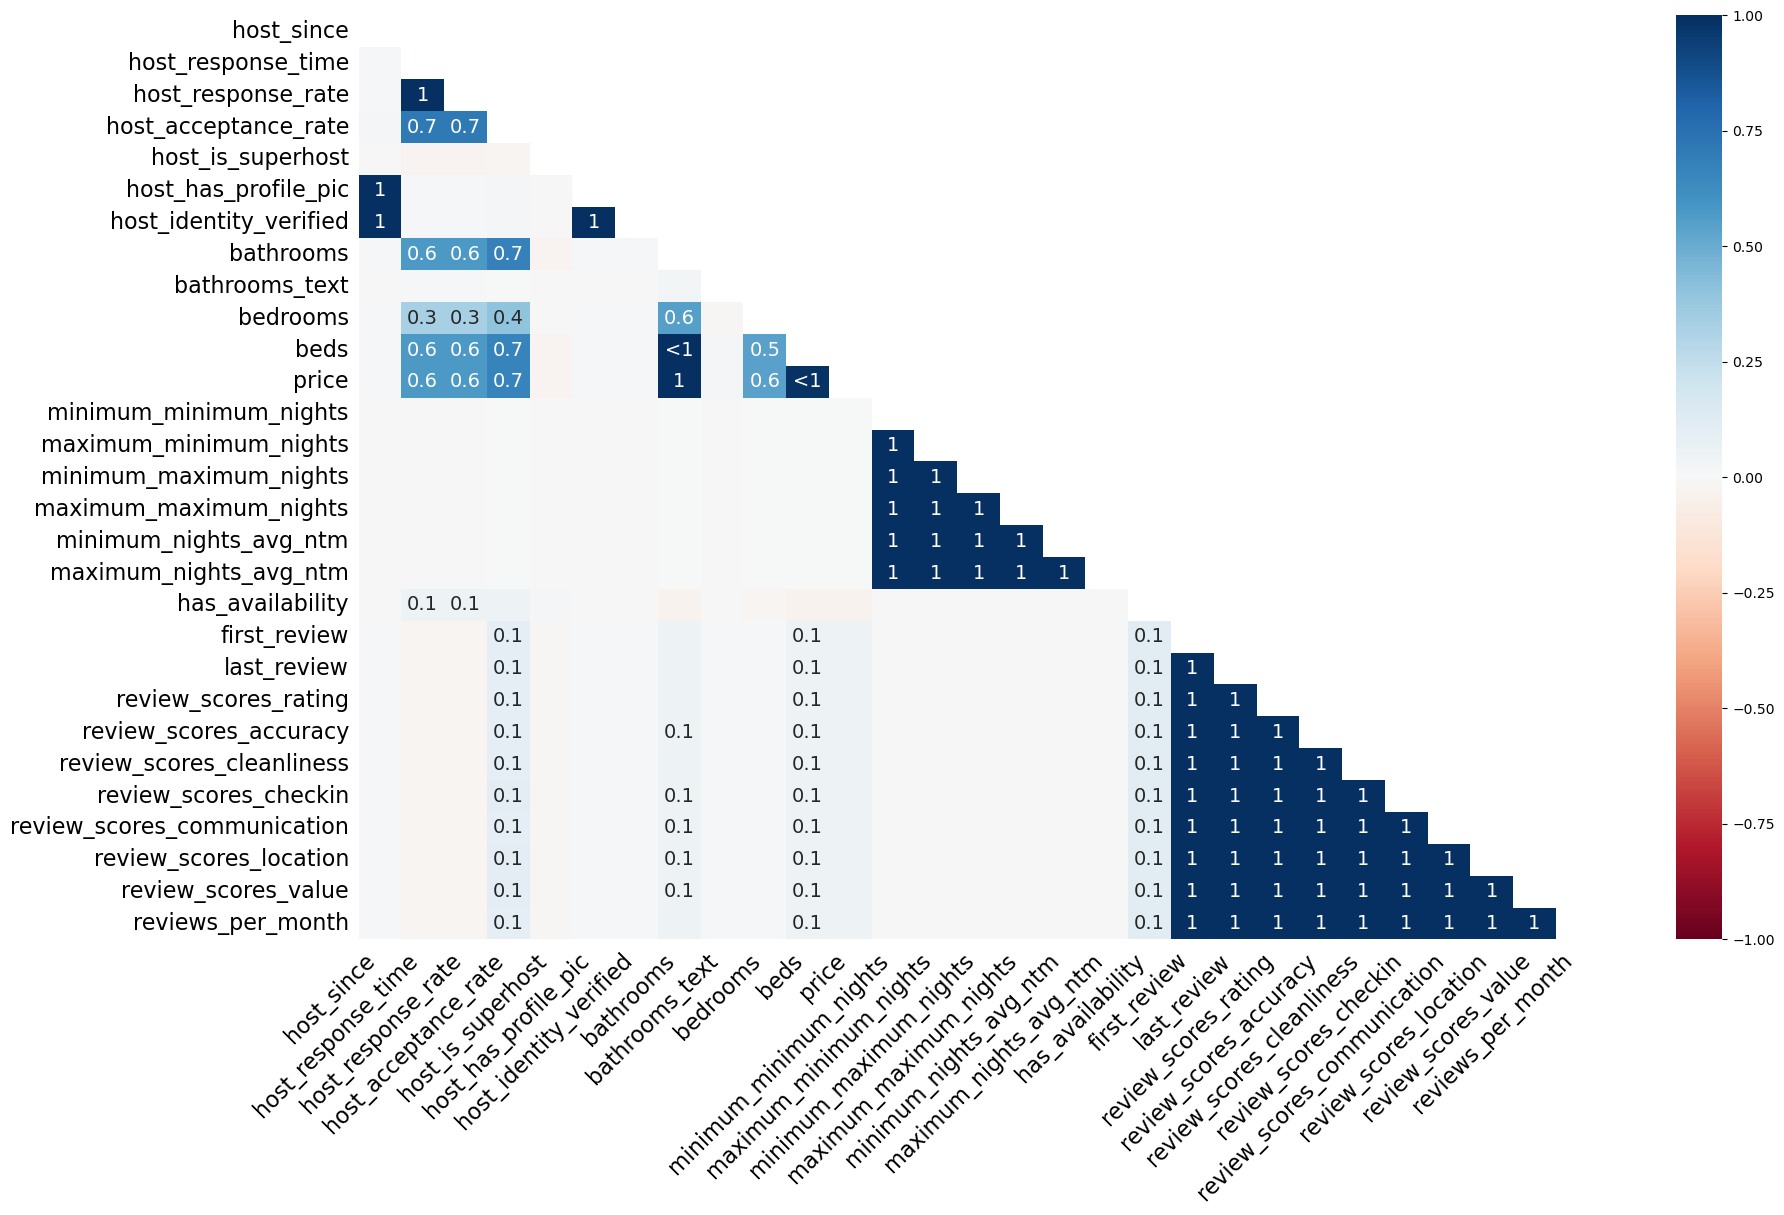

In [6]:
# Visualize the missingness matrix
msno.matrix(df2024_1)
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1)
plt.show()

In [7]:
# drop missing values
columns_to_check = ['host_since', 'host_is_superhost', 'has_availability', 'calendar_updated', 'bathrooms_text','price']
threshold = 0.7  # 70% threshold for missing values

for col in columns_to_check:
    missing_proportion = df2024_1[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        df2024_1.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        df2024_1 = df2024_1.dropna(subset=[col])

In [8]:
# 确定price还在
df2024_1.price.describe()

count       23914
unique        913
top       $100.00
freq          645
Name: price, dtype: object

In [9]:
# fill missing values
# numeric columns
numeric_cols = df2024_1.select_dtypes(include=['number']).columns

# Then identify those numeric columns that have missing values
numeric_cols_with_missing = numeric_cols[df2024_1[numeric_cols].isna().any(axis=0)]

# Now iterate over those columns and print min/max if the minimum is not zero, then fill NaN with 0
for col in numeric_cols_with_missing:
    if df2024_1[col].min(skipna=True) != 0:
        print(f"{col} - Min: {df2024_1[col].min()}, Max: {df2024_1[col].max()}")
        df2024_1[col].fillna(0, inplace=True)

minimum_minimum_nights - Min: 1.0, Max: 500.0
maximum_minimum_nights - Min: 1.0, Max: 1000.0
minimum_maximum_nights - Min: 1.0, Max: 2147483647.0
maximum_maximum_nights - Min: 2.0, Max: 2147483647.0
minimum_nights_avg_ntm - Min: 1.0, Max: 956.8
maximum_nights_avg_ntm - Min: 2.0, Max: 2147483647.0
review_scores_rating - Min: 1.0, Max: 5.0
review_scores_accuracy - Min: 1.0, Max: 5.0
review_scores_cleanliness - Min: 1.0, Max: 5.0
review_scores_checkin - Min: 1.0, Max: 5.0
review_scores_communication - Min: 1.0, Max: 5.0
review_scores_location - Min: 1.0, Max: 5.0
review_scores_value - Min: 1.0, Max: 5.0
reviews_per_month - Min: 0.01, Max: 78.25


In [10]:
# fill missing values
# review columns

# 将字符串转换为Datetime
df2024_1['last_scraped'] = pd.to_datetime(df2024_1['last_scraped'])
for col in ['host_since', 'first_review', 'last_review']:
    # Ensure that the column is in datetime format
    df2024_1[col] = pd.to_datetime(df2024_1[col], errors='coerce')  # Use 'coerce' to handle any parsing errors

# # 添加缺失值标记列
# for col in ['first_review', 'last_review', 'review_scores_rating', 
#             'review_scores_accuracy', 'review_scores_cleanliness', 
#             'review_scores_checkin', 'review_scores_communication', 
#             'review_scores_location', 'review_scores_value']:
    
#     missing_col_name = col + '_missing'  # 新的缺失值标记列名
#     df2024_1[missing_col_name] = df2024_1[col].isna().astype(int)  # 如果缺失则标记为1

# 对于日期列，选择一个填充值，并转换为天数
date_fill_value = df2024_1['first_review'].min(skipna=True)
df2024_1['first_review'].fillna(date_fill_value, inplace=True)
df2024_1['last_review'].fillna(date_fill_value, inplace=True)

# 转换日期列为天数
df2024_1['days_since_first_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['first_review'])).dt.days
df2024_1['days_since_last_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['last_review'])).dt.days
df2024_1['days_since_host_since'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['host_since'])).dt.days
df2024_1['days_since_first_review'] = df2024_1['days_since_first_review'].astype(float)
df2024_1['days_since_last_review'] = df2024_1['days_since_last_review'].astype(float)
df2024_1['days_since_host_since'] = df2024_1['days_since_host_since'].astype(float)

# 对于评分类列，使用中性值填充缺失值
for score_col in ['review_scores_rating', 'review_scores_accuracy', 
                  'review_scores_cleanliness', 'review_scores_checkin', 
                  'review_scores_communication', 'review_scores_location', 
                  'review_scores_value']:
    neutral_value = 2.5
    df2024_1[score_col].fillna(neutral_value, inplace=True)

df2024_1.drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)
# host_since缺失值已经在前面被删掉

In [11]:
# string to float
df2024_1['host_acceptance_rate'] = df2024_1['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df2024_1['host_response_rate'] = df2024_1['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [12]:
columns_to_convert = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]

# Assuming that 't' represents True and 'f' represents False in your dataset
bool_mapping = {'t': True, 'f': False}

for col in columns_to_convert:
    # Map the 't'/'f' values to True/False
    df2024_1[col] = df2024_1[col].map(bool_mapping)

In [13]:
# Remove both the dollar sign and commas, then convert to float
df2024_1['price'] = df2024_1['price'].replace('[\$,]', '', regex=True).astype(float)

In [14]:
missing_values_count = df2024_1.isna().sum()

# Filter and print only those columns that have non-zero missing values
non_zero_missing = missing_values_count[missing_values_count != 0]
print(non_zero_missing)

host_response_time      5466
host_response_rate      5466
host_acceptance_rate    1724
bedrooms                  46
beds                     114
dtype: int64


In [15]:
df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']].describe()

,host_response_rate,host_acceptance_rate,bedrooms,beds
count,18448.000000,22190.000000,23868.000000,23800.000000
mean,0.940187,0.808767,1.374141,1.685210
std,0.176757,0.268407,0.966722,1.256933
min,0.000000,0.000000,0.000000,0.000000
25%,0.990000,0.730000,1.000000,1.000000
50%,1.000000,0.940000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000
max,1.000000,1.000000,16.000000,42.000000


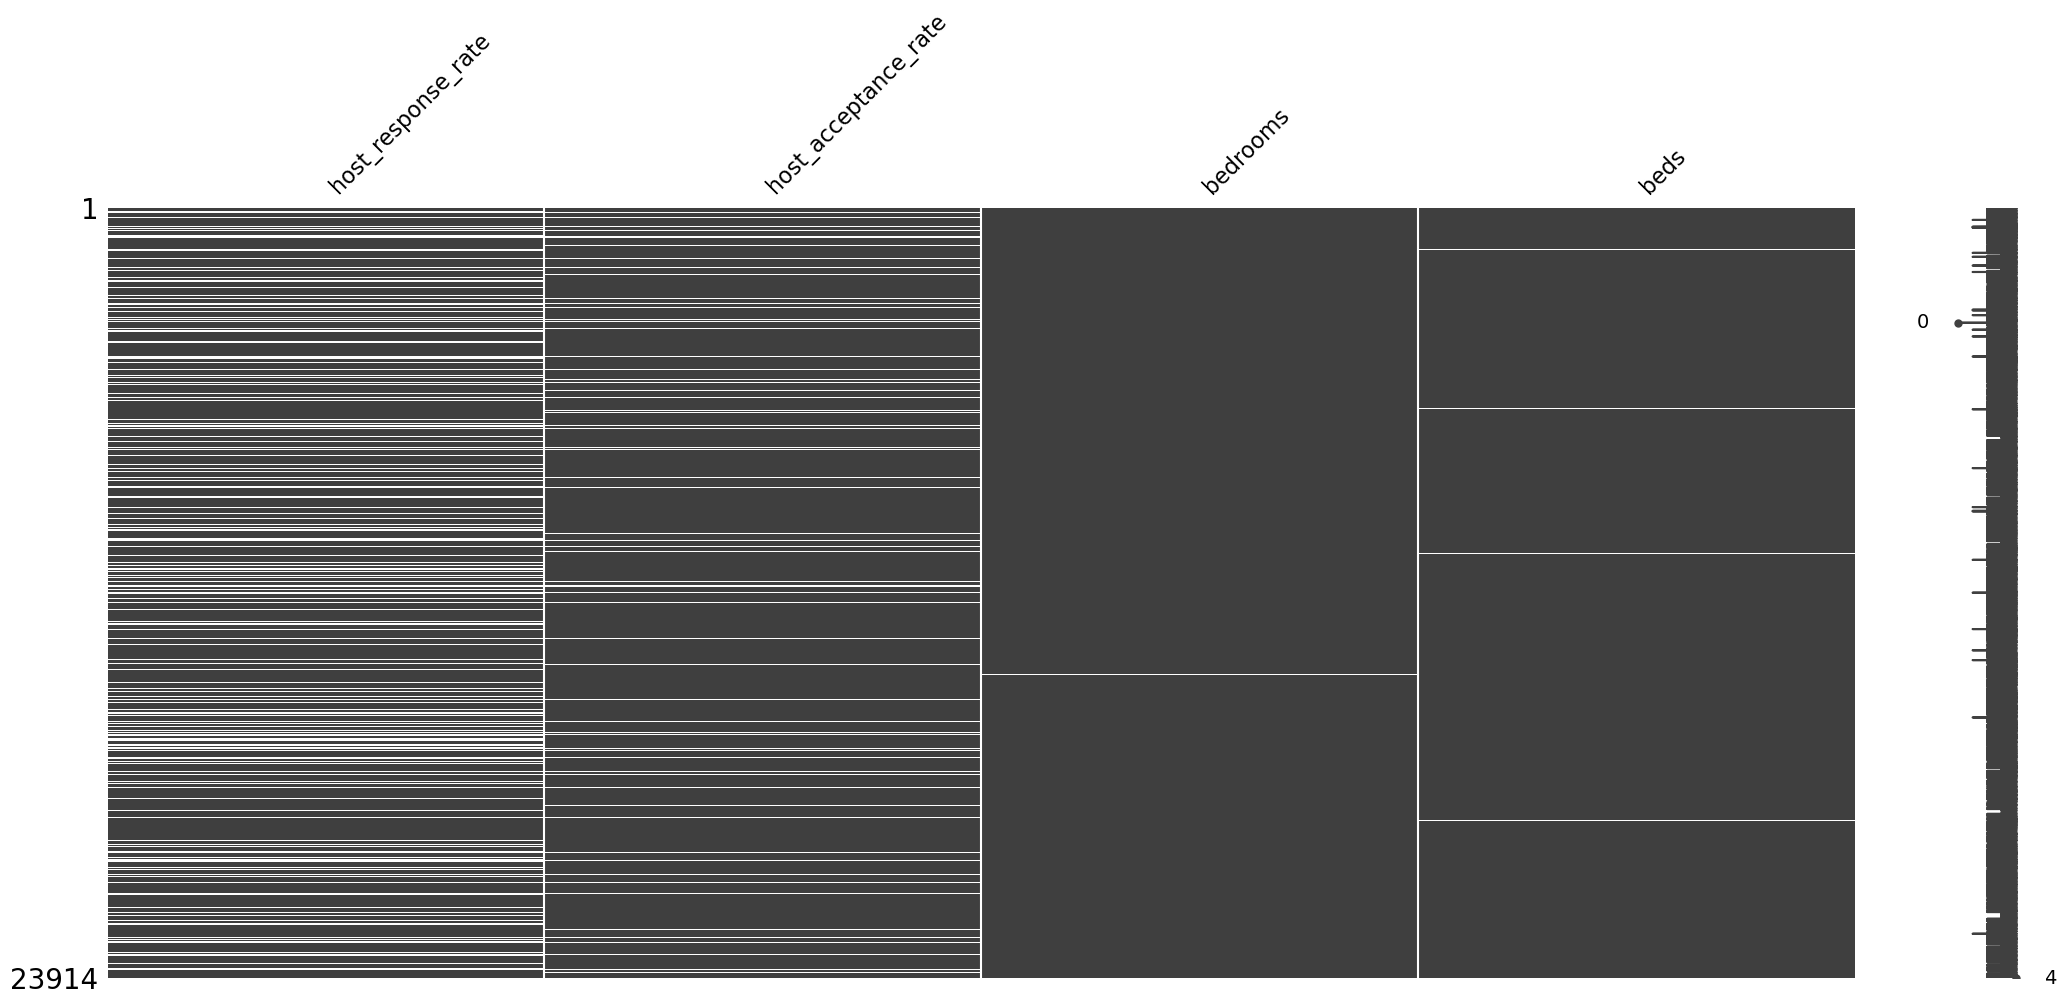

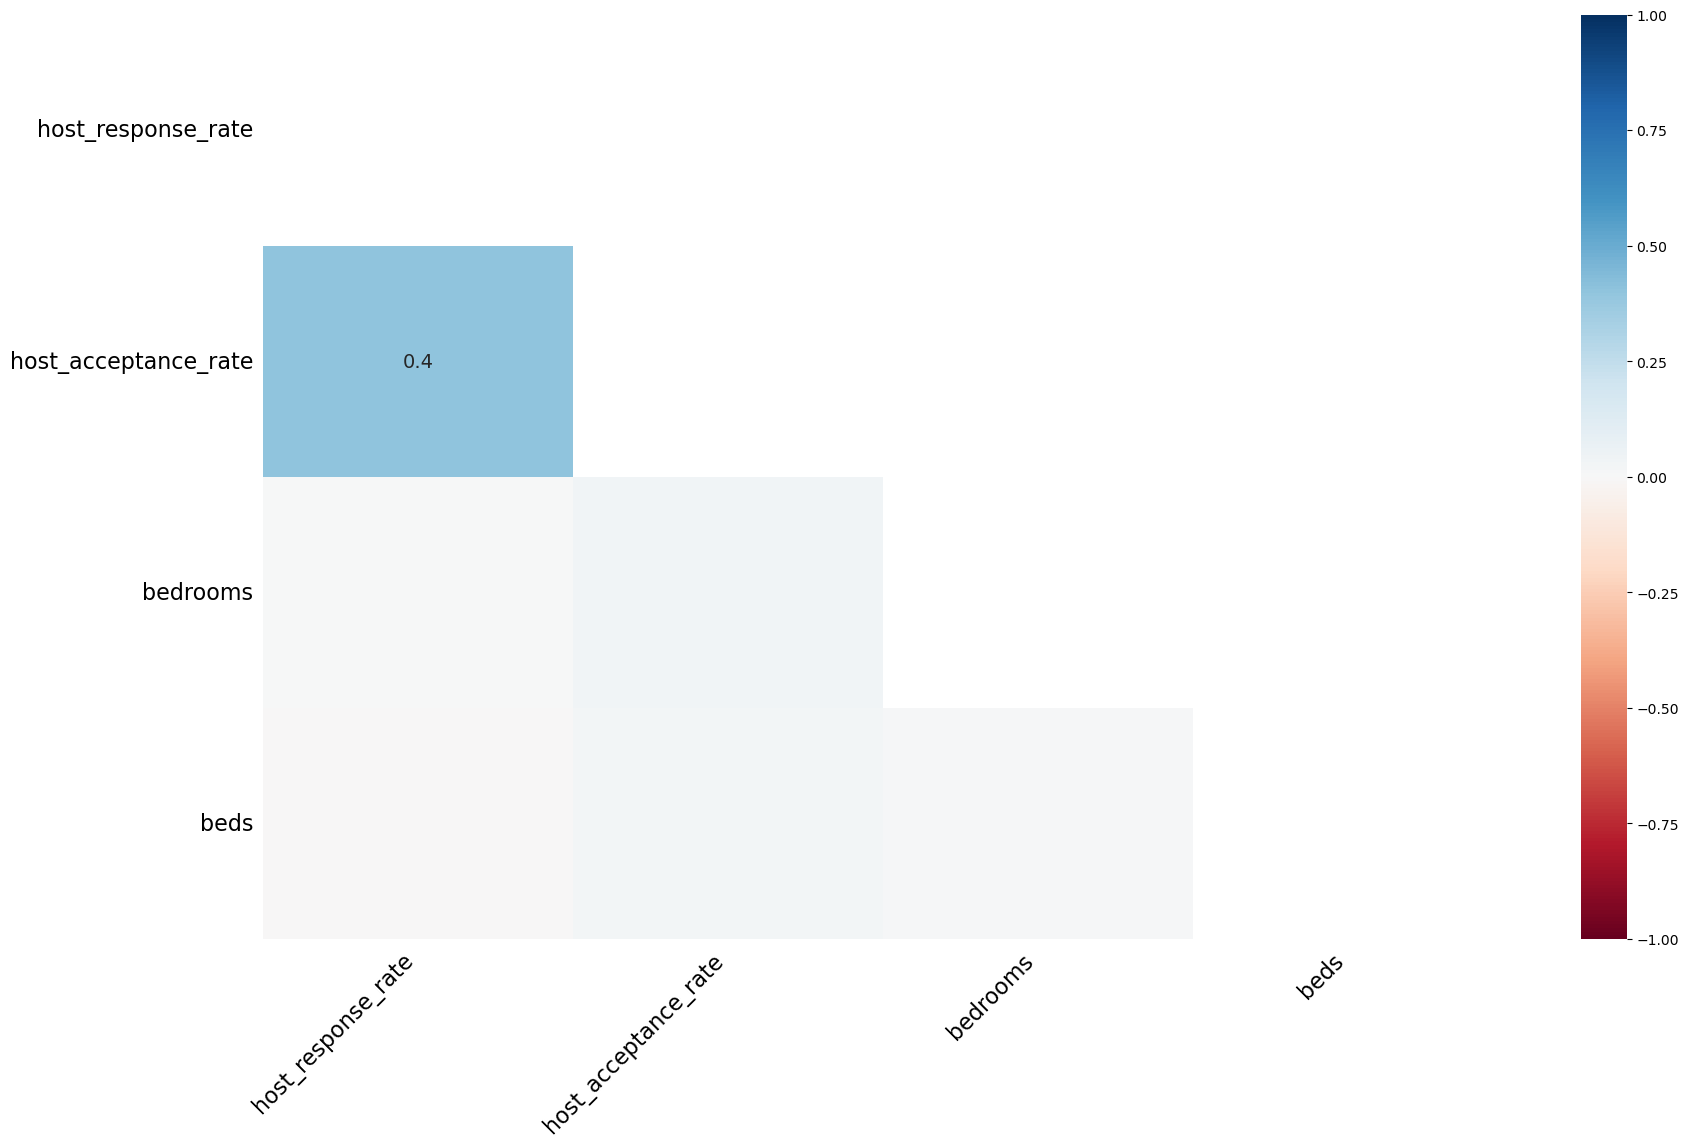

In [16]:
# Visualize the missingness matrix
msno.matrix(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

In [17]:
# 删除包含任何缺失值的行
df2024_1 = df2024_1.dropna(subset=['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds'])

In [18]:
df2024_1.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calc

# Feature Engineering

## multicollinearity

In [19]:
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
df2024_1['review_score_mean'] = df2024_1[review_score_columns].mean(axis=1)
df2024_1.drop(review_score_columns,axis=1,inplace=True)

In [20]:
multicollinearity_drop_columns=[
    'maximum_nights_avg_ntm','availability_60','availability_90','calculated_host_listings_count','minimum_nights_avg_ntm','days_since_first_review','minimum_minimum_nights'
]
df2024_1.drop(multicollinearity_drop_columns,axis=1,inplace=True)

In [21]:
# drop outliers
numeric_cols = df2024_1.select_dtypes(include=['number'])
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(numeric_cols)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
numeric_cols = numeric_cols.drop(numeric_cols.index[outlier_indices])

In [22]:
numeric_cols=numeric_cols[numeric_cols.price<100000]

In [23]:
numeric_cols.shape

(16406, 24)

In [24]:
# numeric_cols = df2024_1.select_dtypes(include=['number'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# 计算VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_cols.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

In [26]:
# 严重多重共线性
has_multiL_problem=vif_data[vif_data['VIF']>=10]
display(has_multiL_problem)

,feature,VIF
0,host_response_rate,37.204860
1,host_acceptance_rate,19.016753
21,days_since_last_review,11.746381
23,review_score_mean,33.729203


## Encode Labels

In [27]:
# 将amenities的每个列表长度计算出来，作为新的特征
df2024_1['amenities_count'] = df2024_1['amenities'].apply(lambda x: len(eval(x)))

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

# 首先，确保amenities里的每个项都是列表
df2024_1['amenities'] = df2024_1['amenities'].apply(eval)

# 使用MultiLabelBinarizer进行one-hot编码
mlb = MultiLabelBinarizer()
amenities_encoded = mlb.fit_transform(df2024_1['amenities'])
amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_, index=df2024_1.index)

# 将新的DataFrame合并回原始DataFrame
df = pd.concat([df2024_1, amenities_df], axis=1)

# 删除原始的amenities列
df2024_1.drop('amenities', axis=1, inplace=True)

In [29]:
label_selected_cols = [
  'host_response_time',
  'bathrooms_text'
 ]
for col in df2024_1.columns:
    if col in label_selected_cols:
        label_encoder = LabelEncoder()
        df2024_1[col]=df2024_1[col].fillna('Missing')
        df2024_1[col + '_LabelEncoded'] = label_encoder.fit_transform(df2024_1[col])
        df2024_1 = df2024_1.drop(columns=[col])

In [30]:
label_selected_cols = [
  'neighbourhood_cleansed',
  'property_type',
  'room_type'
 ]
# 1. 计算中位数和平均房价的阈值
quantiles = df2024_1['price'].quantile([0.25, 0.75])
mean_price = df2024_1['price'].mean()
median_price = df2024_1['price'].median()

# 2. 创建布尔列
df2024_1['expensive_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() < quantiles[0.25])

# 3. 独热编码
df2024_1 = pd.get_dummies(df2024_1, columns=label_selected_cols)

# 4. 删除True个数小于5的列
for col in df2024_1.columns:
    if df2024_1[col].dtype == 'uint8' and df2024_1[col].sum() < 10:
        df2024_1.drop(col, axis=1, inplace=True)

## Outlies

In [31]:
# drop outliers
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(df2024_1)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
df2024_1 = df2024_1.drop(df2024_1.index[outlier_indices])

In [32]:
df2024_1=df2024_1[df2024_1.price<100000]

In [33]:
df2024_1.shape

(18042, 212)

# Models

- 未进行特征选择的模型测试：(模型：xg_reg，rf)
- 使用随机森林进行特征选择后的模型(模型：best_rf_XGB,best_rf_rf)
- 使用XGBoost进行特征选择后的模型(模型：best_xgb_XGB,best_xgb_rf)
- PCA降维后的模型(模型：best_pca_XGB,best_pca_rf)



## Standardization

In [36]:
# X = df2024_1.drop(['price'],axis=1)
features = df2024_1.drop(['price'], axis=1)  # 选择特征列
scaler = preprocessing.StandardScaler().fit(features)  # 拟合scaler

# 使用拟合的scaler来变换数据
X_scaled = scaler.transform(features)

# 创建一个新的DataFrame，用变换后的数据和原来的列名
X = pd.DataFrame(X_scaled, columns=features.columns)
y = np.log(df2024_1[['price']])
# y = df2024_1[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [46]:
from sklearn.metrics import mean_absolute_percentage_error

def scores(X_train, X_test, y_train, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # 计算R2
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    # 计算训练集上的MSE和RMSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    # 计算测试集上的MSE和RMSE
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    # 计算训练集和测试集上的MAPE
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train R2 score: {train_score}, Test R2 score {test_score}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train MAPE: {train_mape}, Test MAPE: {test_mape}")

# 用你的模型实例替换'model'
# scores(X_train, X_test, y_train, y_test, model)


In [171]:
def n_r2score_plot(estimators,mod,X_train, X_test, y_train, y_test):
#     estimators: a list of number
#     mod: 0-XGBoost, 1 - random forest

    train_scores = []
    test_scores = []
    for n in estimators:
        if mod==1:
            model = RandomForestRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        else:
            model = xgb.XGBRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_scores.append(r2_score(y_train, train_pred))
        test_scores.append(r2_score(y_test, test_pred))

    # 绘制线图
    plt.figure(figsize=(10, 6))
    plt.plot(estimators, train_scores, label='Training R2 Score')
    plt.plot(estimators, test_scores, label='Testing R2 Score')
    plt.xlabel('Number of Estimators')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs. Number of Estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

In [82]:
def grid_tune(param_grid, mod, ver, X_train, y_train):
    # 选择模型
    if mod == 0:
        model = xgb.XGBRegressor(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    
    # 初始化网格搜索对象
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='r2', cv=5, verbose=ver, n_jobs=-1)

    # 执行网格搜索
    grid_search.fit(X_train, y_train)  # 使用正确的变量

    # 打印最优参数和对应的评估分数
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R2 Score: ", grid_search.best_score_)

    return grid_search.best_estimator_

In [ ]:
def feature_importance_ranking(model, columns)
    feature_importances = model.feature_importances_

    # 将特征重要性转换为DataFrame以方便绘图
    features_df = pd.DataFrame({'Features': columns, 'Importance Score': feature_importances})
    features_df = features_df.sort_values(by='Importance Score', ascending=False)

    # 绘制特征重要性条形图
    plt.figure(figsize=(50,50))
    sns.barplot(x='Importance Score', y='Features', data=features_df)
    plt.title(f'Feature Importances')
    plt.show()

## test on XGBoost

In [60]:
# 初始化XGBoost回归模型
xg_reg = xgb.XGBRegressor(random_state=42)
xg_reg.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,xg_reg)

Train R2 score: 0.9018660174052541, Test R2 score 0.7952854156261453
Train MSE: 0.06104084158680714, Test MSE: 0.1324583304780387
Train RMSE: 0.2470644482454065, Test RMSE: 0.36394825247284635
Train MAPE: 0.037078397819275605, Test MAPE: 0.05360452057159625


## test on random forest

In [61]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,rf)

Train R2 score: 0.9694770975547183, Test R2 score 0.7883970952851657
Train MSE: 0.01898571324294504, Test MSE: 0.13691534273710573
Train RMSE: 0.1377886542605923, Test RMSE: 0.3700207328476416
Train MAPE: 0.018993218469820952, Test MAPE: 0.052893995960203874


When the $R^2$ score on the training data is significantly higher than the $R^2$ score on the test data, it indicates that the model is overfitting. 

## feature selection-RF

In [98]:
# 打印特征重要性
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 选择重要性得分高于平均水平的特征
sfm = SelectFromModel(rf, threshold='median', prefit=True)
X_train_rf_selected = sfm.transform(X_train)
X_test_rf_selected = sfm.transform(X_test)

In [99]:
# 获取选中的特征的布尔掩码
selected_mask = sfm.get_support()

# 打印被选中的特征名称
selected_features = X_train.columns[selected_mask]
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       ...
       'property_type_Private room in guest suite',
       'property_type_Private room in home',
       'property_type_Private room in rental unit',
       'property_type_Private room in townhouse',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=106)


### baseline model-XGBoost

In [100]:
# 初始化XGBoost回归模型
xg_reg_rf_features = xgb.XGBRegressor(random_state=42)
xg_reg_rf_features.fit(X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,xg_reg_rf_features)

Train R2 score: 0.9140926667034761, Test R2 score 0.7985284070646808
Train MSE: 0.05343567828642179, Test MSE: 0.13035998837399743
Train RMSE: 0.2311615847982138, Test RMSE: 0.3610539964797474
Train MAPE: 0.035108721822020426, Test MAPE: 0.053279516713259936


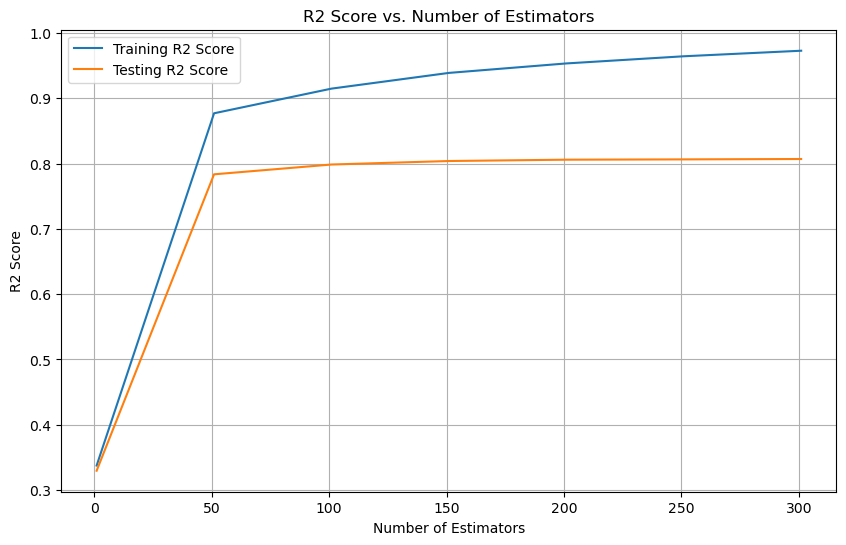

In [101]:
n_r2score_plot(range(1,302,50),0,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [103]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [100,200,250],
    'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_rf_XGB = grid_tune(param_grid, 0, 2, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_XGB)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'min_child_weight': 4, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 1}
Best R2 Score:  0.802672755674228
Train R2 score: 0.959166709229401, Test R2 score 0.8068233178835451
Train MSE: 0.025398932841533484, Test MSE: 0.12499285714643198
Train RMSE: 0.1593704264960519, Test RMSE: 0.35354328892857234
Train MAPE: 0.0239949471189461, Test MAPE: 0.05187461336557684


### baseline model-RF

In [108]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_rf_selected, y_train)

scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9693676025367237, Test R2 score 0.7885736255157351
Train MSE: 0.019053820822717428, Test MSE: 0.13680112078417722
Train RMSE: 0.13803557810476771, Test RMSE: 0.3698663553017187
Train MAPE: 0.01903423960271183, Test MAPE: 0.05297430986810876


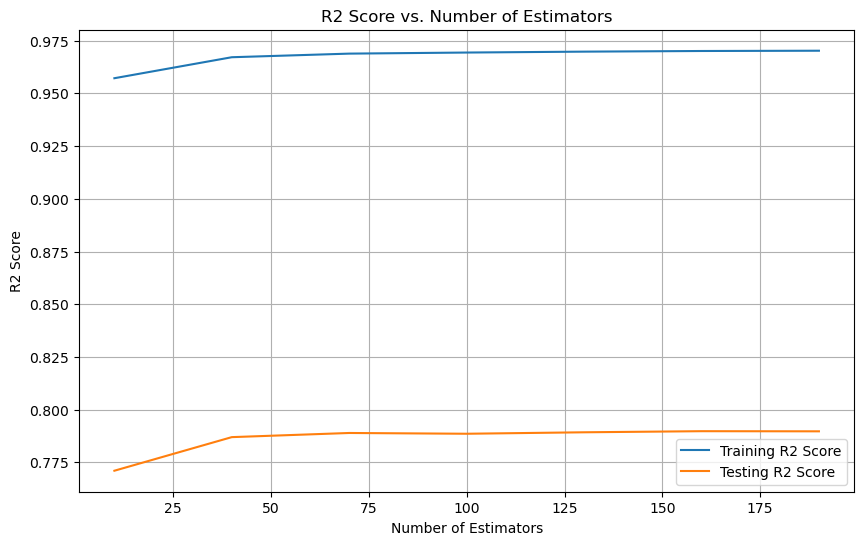

In [110]:
n_r2score_plot(range(10,201,30),1,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [111]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [110,180,250],
#     'max_depth': [10, 20]
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 2, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_rf)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found:  {'n_estimators': 250}
Best R2 Score:  0.78072505032106
Train R2 score: 0.9704543209468435, Test R2 score 0.7900672054770478
Train MSE: 0.018377865312020215, Test MSE: 0.13583471622284107
Train RMSE: 0.1355649855678826, Test RMSE: 0.3685576158795814
Train MAPE: 0.01879122948682203, Test MAPE: 0.0527798393119951


## feature selection-XGBoost

In [112]:
# 使用内置的特征重要性
selection = SelectFromModel(xg_reg, prefit=True, threshold='median')  # threshold可以是具体的数值或者字符串，如'median'
X_train_XGB_selected = selection.transform(X_train)
X_test_XGB_selected = selection.transform(X_test)


# 查看被选中的特征数量
selected_features_count = X_train_XGB_selected.shape[1]
# 获取被选中的特征名
selected_features = X_train.columns[(selection.get_support())]

# 打印被选中的特征名
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_identity_verified',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'maximum_minimum_nights',
       ...
       'property_type_Private room in loft',
       'property_type_Private room in rental unit',
       'property_type_Private room in townhouse',
       'property_type_Room in aparthotel',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'property_type_Shared room in rental unit', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=106)


### baseline model-XGBoost

In [113]:
# 初始化XGBoost回归模型
xg_reg_xg_features = xgb.XGBRegressor(random_state=42)
xg_reg_xg_features.fit(X_train_XGB_selected, y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,xg_reg_xg_features)

Train R2 score: 0.9093143968924589, Test R2 score 0.7944947009220149
Train MSE: 0.05640783536067202, Test MSE: 0.13296995377011586
Train RMSE: 0.23750333757796335, Test RMSE: 0.3646504542299596
Train MAPE: 0.036042907597026885, Test MAPE: 0.053714738115888346


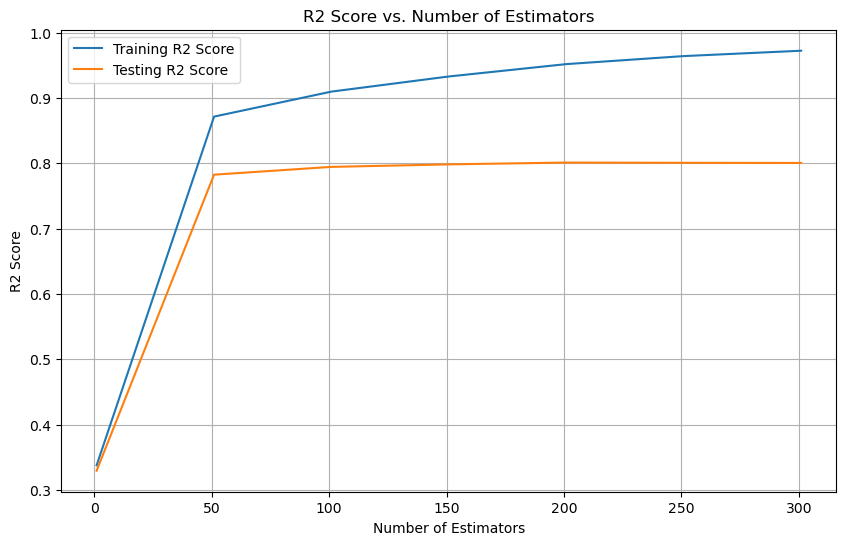

In [114]:
n_r2score_plot(range(1,302,50),0,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [115]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [100,200,250],
    'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_xgb_XGB = grid_tune(param_grid, 0, 2, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected, X_test_XGB_selected,y_train,y_test,best_xgb_XGB)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters found:  {'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 0.1}
Best R2 Score:  0.8004272915949502
Train R2 score: 0.9460600142171584, Test R2 score 0.8061407109431105
Train MSE: 0.03355149806731012, Test MSE: 0.12543453049363992
Train RMSE: 0.18317068015190127, Test RMSE: 0.3541673763824668
Train MAPE: 0.027619874505555208, Test MAPE: 0.05182014445073833


### baseline model-RF

In [116]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_XGB_selected, y_train)

scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9693815263081181, Test R2 score 0.7874330964966991
Train MSE: 0.01904516002345599, Test MSE: 0.13753908759873196
Train RMSE: 0.13800420291953427, Test RMSE: 0.3708626263169854
Train MAPE: 0.019015400163214024, Test MAPE: 0.05298527164586237


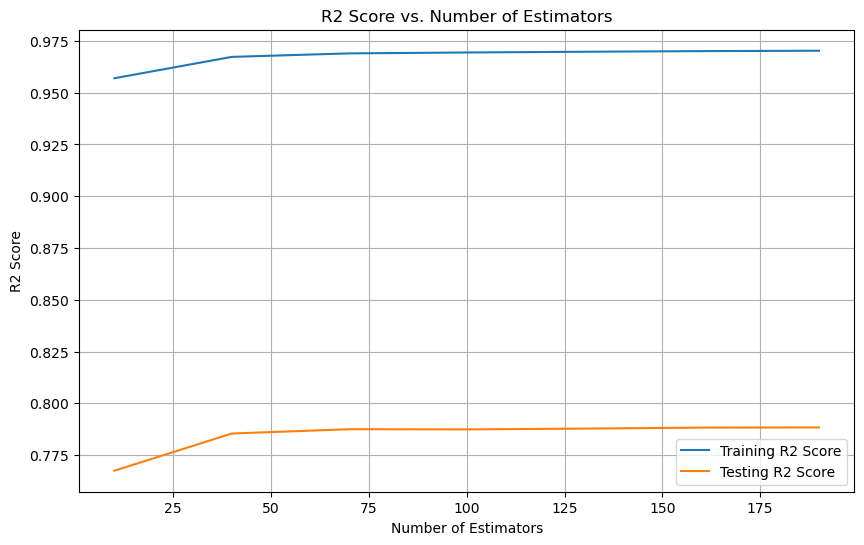

In [117]:
n_r2score_plot(range(10,201,30),1,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [119]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [110,150,200,300],
#     'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 2, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,best_rf_rf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 300}
Best R2 Score:  0.7805362098315902
Train R2 score: 0.9704644595682708, Test R2 score 0.7887075884033503
Train MSE: 0.018371558934065363, Test MSE: 0.13671444156445378
Train RMSE: 0.13554172396006095, Test RMSE: 0.3697491603296129
Train MAPE: 0.018805524967112627, Test MAPE: 0.052809306080738576


## feature selection-PCA

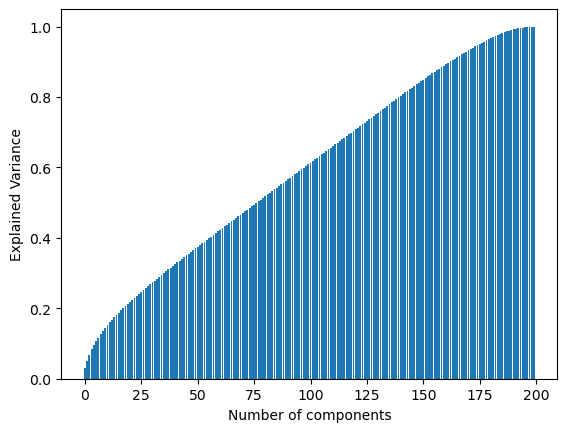

In [165]:
#plot explained variance over the number of compinents
# try to find a best component num
pca = PCA(X.shape[1])
X_S=pca.fit_transform(X)
eigenvalues = pca.explained_variance_ratio_
n= 200
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [154]:
bestPCA = PCA(106)
X_PCA_S_after=bestPCA.fit_transform(X)
X_PCA_S_after.shape

(18042, 106)

In [155]:
components = pd.DataFrame(bestPCA.components_,columns=X.columns)
top_features = components.abs().idxmax(axis=1)

In [156]:
print(top_features)

0                               cheap_room_type
1                             reviews_per_month
2                   property_type_Room in hotel
3                                      bedrooms
4                         room_type_Shared room
                         ...                   
101               neighbourhood_cleansed_Nolita
102    neighbourhood_cleansed_Kew Gardens Hills
103              neighbourhood_cleansed_Tribeca
104          neighbourhood_cleansed_Brownsville
105             neighbourhood_cleansed_Flushing
Length: 106, dtype: object


In [157]:
X_train_PCA_selected, X_test_PCA_selected, y_train, y_test = train_test_split(X_PCA_S_after, y, test_size=0.2, random_state=99)

### baseline model-XGBoost

In [158]:
# 初始化XGBoost回归模型
xg_reg_pca_features = xgb.XGBRegressor(random_state=42)
xg_reg_pca_features.fit(X_train_PCA_selected, y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,xg_reg_pca_features)

Train R2 score: 0.9506158628803593, Test R2 score 0.7527472911587579
Train MSE: 0.030717690356760762, Test MSE: 0.15998215818113595
Train RMSE: 0.17526462950852564, Test RMSE: 0.39997769710464603
Train MAPE: 0.026933703938745664, Test MAPE: 0.05925322327190551


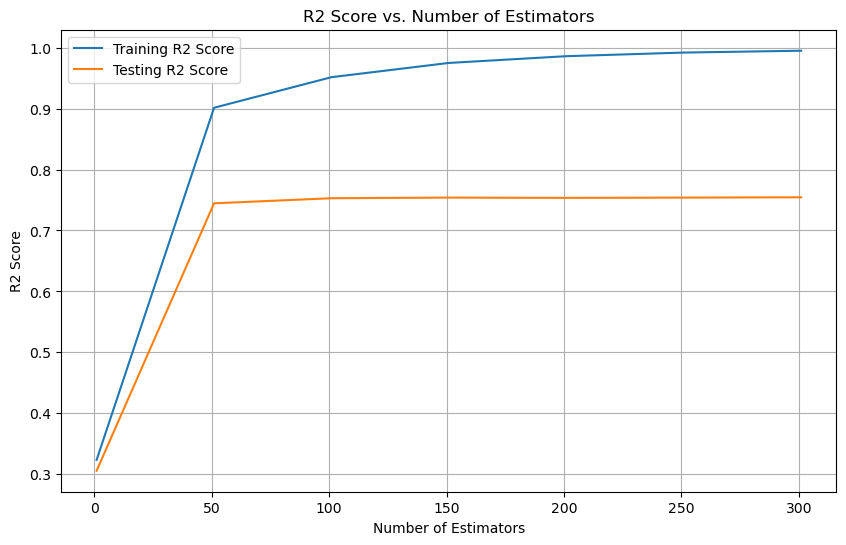

In [159]:
n_r2score_plot(range(1,302,50),0,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

In [160]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [50,100,200,300],
#     'min_child_weight':range(2,6),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_pca_XGB = grid_tune(param_grid, 0, 2, X_train_PCA_selected,y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,best_pca_XGB)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found:  {'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Best R2 Score:  0.7451662089936998
Train R2 score: 0.980641588607267, Test R2 score 0.7528482118904275
Train MSE: 0.01204122865445924, Test MSE: 0.15991685852665138
Train RMSE: 0.10973253234323557, Test RMSE: 0.3998960596538198
Train MAPE: 0.01655072880195213, Test MAPE: 0.05860814614685541


### baseline model-RF

In [170]:
# baseline model
pca_rf_features = RandomForestRegressor(random_state=42,n_jobs=-1)
pca_rf_features.fit(X_train_PCA_selected, y_train)

scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,pca_rf_features)

Train R2 score: 0.9653323801979388, Test R2 score 0.7556923290489512
Train MSE: 0.02156379097817821, Test MSE: 0.15807660365837087
Train RMSE: 0.14684614730451123, Test RMSE: 0.3975884853191436
Train MAPE: 0.020874986769144066, Test MAPE: 0.057770564501017266


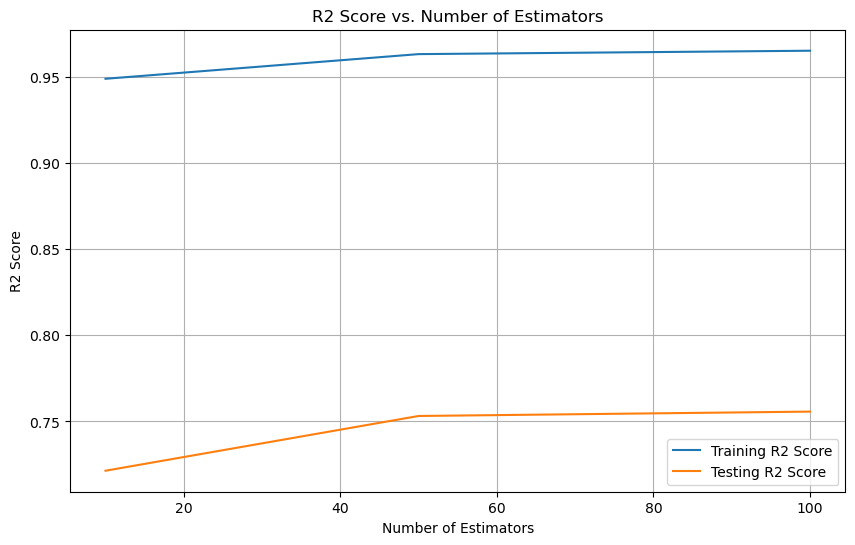

In [173]:
n_r2score_plot([10,50,100],1,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

# Results

<tbody><tr height="29.50" style="height:14.75pt;">
    <td class="xl66" height="63" width="301" rowspan="2" style="height:31.50pt;width:150.50pt;border-right:.5pt solid #000000;border-bottom:1.5pt solid #000000;" x:str="">feature selection method</td>
    <td class="xl67" width="169" rowspan="2" style="width:84.50pt;border-right:.5pt solid windowtext;border-bottom:1.5pt solid windowtext;" x:str="">model</td>
    <td class="xl68" width="387.20" colspan="4" style="width:193.60pt;border-right:.5pt solid windowtext;border-bottom:.5pt solid windowtext;" x:str="">training data</td>
    <td class="xl69" width="387.20" colspan="4" style="width:193.60pt;border-right:none;border-bottom:.5pt solid windowtext;" x:str="">testing data</td>
   </tr>
   <tr height="33.50" style="height:16.75pt;">
    <td class="xl72" x:str="">R<font class="font20"><sup>2</sup></font></td>
    <td class="xl73" x:str="">MSE</td>
    <td class="xl73" x:str="">RMSE</td>
    <td class="xl74" x:str="">MAPE</td>
    <td class="xl74" x:str="">R<font class="font20"><sup>2</sup></font></td>
    <td class="xl73" x:str="">MSE</td>
    <td class="xl73" x:str="">RMSE</td>
    <td class="xl84" x:str="">MAPE</td>
   </tr>
   <tr height="29.50" style="height:14.75pt;">
    <td class="xl75" height="57.50" rowspan="2" style="height:28.75pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">None</td>
    <td class="xl76" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.969477097554718">0.9695<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8985713242944999e-002">0.0190<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.137788654260592">0.1378<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.89932184698209e-002">0.0190<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.78839709528516499">0.7884<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13691534273710501">0.1369<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.37002073284764098">0.3700<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.2893995960203798e-002">0.0529<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.90186601740525396">0.9019<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="6.1040841586807101e-002">0.0610<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.24706444824540599">0.2471<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="3.7078397819275598e-002">0.0371<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.79528541562614496">0.7953<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13245833047803801">0.1325<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36394825247284601">0.3639<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.3604520571596197e-002">0.0536<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="56" rowspan="2" style="height:28.00pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">Random Forest</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.97045432094684303">0.9705<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8377865312020202e-002">0.0184<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13556498556788199">0.1356<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8791229486821999e-002">0.0188<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.79006720547704701">0.7901<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13583471622284099">0.1358<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36855761587958102">0.3686<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.2779839311995098e-002">0.0528<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.95916670922940095">0.9592<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.5398932841533401e-002">0.0254<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.15937042649605099">0.1594<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.3994947118946099e-002">0.0240<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.806823317883545">0.8068<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.12499285714643101">0.1250<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.35354328892857201">0.3535<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.1874613365576798e-002">0.0519<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="56" rowspan="2" style="height:28.00pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">XGBoost</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.97046445956826999">0.9705<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.83715589340653e-002">0.0184<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13554172396006001">0.1355<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8805524967112599e-002">0.0188<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.78870758840334998">0.7887<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.136714441564453">0.1367<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36974916032961203">0.3697<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.28093060807385e-002">0.0528<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.94606001421715802">0.9461<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="3.3551498067310101e-002">0.0336<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.18317068015190099">0.1832<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.7619874505555201e-002">0.0276<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.80614071094311002">0.8061<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.12543453049363901">0.1254<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.35416737638246598">0.3542<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.1820144450738299e-002">0.0518<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="57.50" rowspan="2" style="height:28.75pt;border-right:.5pt solid #000000;border-bottom:1.0pt solid #000000;" x:str="">PCA</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.96533238019793799">0.9653<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.1563790978178201e-002">0.0216<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.14684614730451101">0.1468<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.0874986769144e-002">0.0209<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.75569232904895101">0.7557<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.15807660365837001">0.1581<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.39758848531914298">0.3976<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.7770564501017203e-002">0.0578<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="29.50" style="height:14.75pt;">
    <td class="xl81" x:str="">XGBoost</td>
    <td class="xl82" x:num="0.98064158860726702">0.9806<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="1.20412286544592e-002">0.0120<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.109732532343235">0.1097<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="1.6550728801952099e-002">0.0166<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.75284821189042705">0.7528<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.159916858526651">0.1599<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.39989605965381902">0.3999<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="5.8608146146855403e-002">0.0586<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <!--[if supportMisalignedColumns]-->
    <tr width="0" style="display:none;">
     <td width="301" style="width:151;"></td>
     <td width="169" style="width:85;"></td>
     <td width="97" style="width:48;"></td>
    </tr>
   <!--[endif]-->
  </tbody>